# Lab: Bring your own script with Amazon SageMaker

## TensorFlow script mode training and serving
Script mode is a training script format for TensorFlow that lets you execute any TensorFlow training script in SageMaker with minimal modification. The [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) handles transferring your script to a SageMaker training instance. On the training instance, SageMaker's native TensorFlow support sets up training-related environment variables and executes your training script. In this tutorial, we use the SageMaker Python SDK to launch a training job and deploy the trained model.

Script mode supports training with a Python script, a Python module, or a shell script. In this example, we use a Python script to train a classification model on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). In this example, we will show how easily you can train a SageMaker using TensorFlow 1.x and TensorFlow 2.0 scripts with SageMaker Python SDK. In addition, this notebook demonstrates how to perform real time inference with the [SageMaker TensorFlow Serving container](https://github.com/aws/sagemaker-tensorflow-serving-container). The TensorFlow Serving container is the default inference method for script mode. For full documentation on the TensorFlow Serving container, please visit [here](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow).

# Set up the environment
Let's start by setting up the environment:

In [3]:
# cell 01
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

In [4]:
role

'arn:aws:iam::071908484098:role/service-role/AmazonSageMaker-ExecutionRole-20220308T154036'

# Training Data
The MNIST dataset has been loaded to the public S3 buckets `sagemaker-sample-data-<REGION>` under the prefix `tensorflow/mnist`. There are four .npy file under this prefix:

- train_data.npy
- eval_data.npy
- train_labels.npy
- eval_labels.npy

In [5]:
# cell 02
training_data_uri = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)
training_data_uri

's3://sagemaker-sample-data-eu-west-1/tensorflow/mnist'

# Construct a script for distributed training
This tutorial's training script was adapted from TensorFlow's official CNN MNIST example. We have modified it to handle the `model_dir` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

At the end of the training job we have added a step to export the trained model to the path stored in the environment variable `SM_MODEL_DIR`, which always points to `/opt/ml/model`. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

Here is the entire script:

![image.png](https://miro.medium.com/max/666/1*noYcUAa_P8nRilg3Lt_nuA.png)

![image.png](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

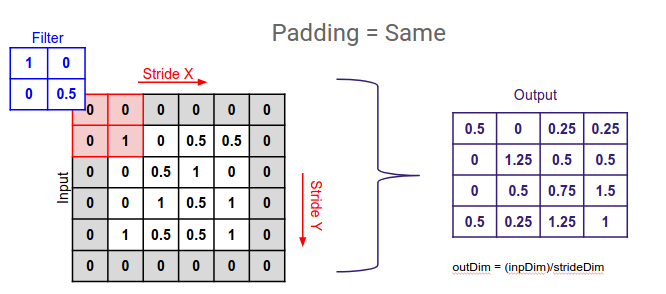

### 'mnist.py' Network Architecture
https://medium.com/@snehitha_tiger/for-a-beginner-how-to-start-with-cnn-using-mnist-dataset-6f9a05d92c50


![image.png](https://miro.medium.com/max/1400/1*KBeNeqFn1Kgt9LfM7l42hA.png)


![image.png](https://qph.fs.quoracdn.net/main-qimg-07e35ae21eb9cda29813a0683545eb25)


In [6]:
# cell 03
# Pygments: Python Syntax highlighter，以高亮的形式输出python文件的内容
!pygmentize 'mnist.py'

sh: 0: getcwd() failed: No such file or directory
sh: 0: getcwd() failed: No such file or directory
# Copyright 2018-2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import os
import json
import argparse
from tensorflow.python.platform import tf_logging
import log

In [8]:
# TensorFlow 2.1 script
!pygmentize 'mnist-2.py'

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='a

# Create a training job using the TensorFlow estimator
The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container, uploading your script to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

`py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting py_version to `py2` and `script_mode` to True.

`distribution` is used to configure the distributed training setup. It's required only if you are doing distributed training either across a cluster of instances or across multiple GPUs. Here we are using parameter servers as the distributed training schema. SageMaker training jobs run on homogeneous clusters. To make parameter server more performant in the SageMaker setup, we run a parameter server on every instance in the cluster, so there is no need to specify the number of parameter servers to launch. Script mode also supports distributed training with [Horovod](https://github.com/horovod/horovod). You can find the full documentation on how to configure distributions [here](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow#distributed-training).

In [ ]:
# cell 04
from sagemaker.tensorflow import TensorFlow


mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             instance_count=2,
                             instance_type='ml.p3.2xlarge',
                             framework_version='1.15.2',
                             py_version='py3',
                             distribution={'parameter_server': {'enabled': True}})

You can also initiate an estimator to train with TensorFlow 2.1 script. The only things that you will need to change are the script name and `framework_version`

In [ ]:
# cell 05
mnist_estimator2 = TensorFlow(entry_point='mnist-2.py',
                             role=role,
                             instance_count=2,
                             instance_type='ml.p3.2xlarge',
                             framework_version='2.1.0',
                             py_version='py3',
                             distribution={'parameter_server': {'enabled': True}})

# Calling `fit`
To start a training job, we call `estimator.fit(training_data_uri)`.

An S3 location is used here as the input. fit creates a default channel named 'training', which points to this S3 location. In the training script we can then access the training data from the location stored in SM_CHANNEL_TRAINING. fit accepts a couple other types of input as well. See the API doc [here](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) for details.

When training starts, the TensorFlow container executes mnist.py, passing hyperparameters and model_dir from the estimator as script arguments. Because we didn't define either in this example, no hyperparameters are passed, and model_dir defaults to `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`, so the script execution is as follows:

`python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`

When training is complete, the training job will upload the saved model for TensorFlow serving.

In [ ]:
# cell 06
mnist_estimator.fit(training_data_uri)

Calling fit to train a model with TensorFlow 2.1 script.

In [ ]:
# cell 07
mnist_estimator2.fit(training_data_uri)

# Deploy the trained model to an endpoint
The `deploy()` method creates a SageMaker model, which is then deployed to an endpoint to serve prediction requests in real time. We will use the TensorFlow Serving container for the endpoint, because we trained with script mode. This serving container runs an implementation of a web server that is compatible with SageMaker hosting protocol. The [Using your own inference code](https://render.githubusercontent.com/view/ipynb?color_mode=auto&commit=a5c9a21e6ed70fd51ab5178f3a35461473f7b379&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6177732f616d617a6f6e2d736167656d616b65722d6578616d706c65732f613563396132316536656437306664353161623531373866336133353436313437336637623337392f736167656d616b65722d707974686f6e2d73646b2f74656e736f72666c6f775f7363726970745f6d6f64655f747261696e696e675f616e645f73657276696e672f74656e736f72666c6f775f7363726970745f6d6f64655f747261696e696e675f616e645f73657276696e672e6970796e62&nwo=aws%2Famazon-sagemaker-examples&path=sagemaker-python-sdk%2Ftensorflow_script_mode_training_and_serving%2Ftensorflow_script_mode_training_and_serving.ipynb&repository_id=107937815&repository_type=Repository) document explains how SageMaker runs inference containers.

In [ ]:
# cell 08
predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Deployed the trained TensorFlow 2.1 model to an endpoint.

In [ ]:
# cell 09
predictor2 = mnist_estimator2.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# Invoke the endpoint
Let's download the training data and use that as input for inference.

In [ ]:
# cell 10
import numpy as np

!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_data.npy train_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_labels.npy train_labels.npy

train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

The formats of the input and the output data correspond directly to the request and response formats of the Predict method in the [TensorFlow Serving REST API](https://www.tensorflow.org/serving/api_rest). SageMaker's TensforFlow Serving endpoints can also accept additional input formats that are not part of the TensorFlow REST API, including the simplified JSON format, line-delimited JSON objects ("jsons" or "jsonlines"), and CSV data.

In this example we are using a numpy array as input, which will be serialized into the simplified JSON format. In addtion, TensorFlow serving can also process multiple items at once as you can see in the following code. You can find the complete documentation on how to make predictions against a TensorFlow serving SageMaker endpoint [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst#making-predictions-against-a-sagemaker-endpoint).

In [ ]:
# cell 11
predictions = predictor.predict(train_data[:50])
for i in range(0, 50):
    prediction = predictions['predictions'][i]['classes']
    label = train_labels[i]
    print('prediction is {}, label is {}, matched: {}'.format(prediction, label, prediction == label))

Examine the prediction result from the TensorFlow 2.1 model.

In [ ]:
# cell 12
predictions2 = predictor2.predict(train_data[:50])
for i in range(0, 50):
    prediction = np.argmax(predictions2['predictions'][i])
    label = train_labels[i]
    print('prediction is {}, label is {}, matched: {}'.format(prediction, label, prediction == label))

# Delete the endpoint
Let's delete the endpoint we just created to prevent incurring any extra costs and then [verify](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html)

In [ ]:
# cell 13
predictor.delete_endpoint()

In [ ]:
# cell 14
predictor2.delete_endpoint()

In [ ]:
# cell 15
